In [14]:
# B3Service

In [39]:

from dataclasses import dataclass, field
from pathlib import Path
from typing import Set, List

import pandas as pd


@dataclass
class B3Service:
    """
    B3Service: A service for obtaining B3 tickers from portfolio composition files.

    Args:
    - portfolio_composition_path (Path): The path to the directory containing portfolio composition files.

    Attributes:
    - portfolio_composition_path (Path): The path to the directory containing portfolio composition files.
    """

    portfolio_composition_path: Path
    tickers: Set[str] = field(default_factory=set)

    def _is_valid_ticker(self, ticker: str) -> bool:
        """
        Checks if a ticker is valid.

        Args:
        - ticker (str): Ticker to be validated.

        Returns:
        - bool: True if the ticker is valid, False otherwise.
        """
        return bool(re.match(r"^[A-Z]{4}\d{1,2}$", ticker))

    def _read_tickers_from_file(self, file: Path) -> pd.Series:
        """
        Reads tickers from a given file.

        Args:
        - file (Path): The file from which tickers need to be read.

        Returns:
        - pd.Series: Series containing tickers.
        """
        return pd.read_csv(
            str(file.absolute()), encoding="iso-8859-1", delimiter=";", index_col=False, usecols=[0]
        ).iloc[:, 0]

    def _update_tickers(self, new_tickers: Set[str]) -> None:
        """
        Updates the set of tickers.

        Args:
        - new_tickers (Set[str]): New tickers to be added.
        """
        self.tickers.update(new_tickers)

    def get_b3_tickers(self) -> Set[str]:
        """
        Gets B3 tickers from portfolio composition files.

        Returns:
        - Set[str]: Set of B3 tickers.
        """
        for file in self.portfolio_composition_path.iterdir():
            if not file.is_file() or file.suffix != ".csv":
                continue

            raw_tickers = self._read_tickers_from_file(file)

            valid_tickers = {ticker for ticker in raw_tickers if self._is_valid_ticker(ticker)}
            self._update_tickers(valid_tickers)

        return self.tickers

    def get_b3_tickers_in_yahoo_format(self) -> List[str]:
        return [f"{ticker}.SA" for i, ticker in enumerate(self.get_b3_tickers()) if i < 20]


In [40]:
portfolio_composition_path = Path("data/B3/portfolio_composition")
b3_service = B3Service(portfolio_composition_path)
b3_tickers = b3_service.get_b3_tickers_in_yahoo_format()

b3_tickers

['BHIA3.SA',
 'PLPL3.SA',
 'YDUQ3.SA',
 'MYPK3.SA',
 'VAMO3.SA',
 'HBSA3.SA',
 'CPLE3.SA',
 'BRFS3.SA',
 'UNIP6.SA',
 'PRIO3.SA',
 'AERI3.SA',
 'AURE3.SA',
 'AMBP3.SA',
 'CPLE6.SA',
 'SBFG3.SA',
 'TEND3.SA',
 'CURY3.SA',
 'ARZZ3.SA',
 'ALUP11.SA',
 'LREN3.SA']

# PortfolioOptimizer

In [109]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import riskfolio as rp
import matplotlib.pyplot as plt
from pathlib import Path


class AssetAnalysisAI:
    def __init__(self, assets, start, end, portfolio_composition_path):
        self.assets = assets
        self.start = start
        self.end = end
        self.portfolio_composition_path = portfolio_composition_path
        self.data = None
        self.returns = None
        self.optimal_portfolios = None

    def download_data(self):
        self.data = yf.download(self.assets, start=self.start, end=self.end)
        self.data = self.data.loc[:, ('Adj Close', slice(None))]
        self.data.columns = self.assets

    def calculate_returns(self):
        self.returns = self.data[self.assets].pct_change().dropna()

    def estimate_mean_variance_portfolio(self, returns, risk_measure='MV', objective='Sharpe', rf=0, hist=True, min_weight=0.01):
        # Step 1: Create constraints for minimum weight
        constraints = pd.DataFrame({
            'Disabled': [False],
            'Type': ['All Assets'],
            'Set': [''],
            'Position': [''],
            'Sign': ['>='],
            'Weight': [min_weight],
            'Type Relative': [''],
            'Relative Set': [''],
            'Relative': [''],
            'Factor': ['']
        })
    
        # Step 2: Create constraints for asset classes
        asset_classes = pd.DataFrame({'Assets': returns.columns, 'Industry': [''] * len(returns.columns)})
        A, B = rp.assets_constraints(constraints, asset_classes)
    
        # Step 3: Create the Portfolio object
        port = rp.Portfolio(returns=returns)
    
        # Step 4: Calculate asset statistics
        method_mu, method_cov = 'hist', 'hist'
        port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
    
        # Step 5: Set the constraints
        port.ainequality, port.binequality = A, B
    
        # Step 6: Estimate optimal portfolio
        model = 'Classic'
        w = port.optimization(model=model, rm=risk_measure, obj=objective, rf=rf, hist=hist)
    
        return w



    def plot_portfolio_composition(self, weights, title, cmap='tab20'):
        ax = rp.plot_pie(w=weights, title=title, others=0.05, nrow=25, cmap=cmap, height=6, width=10, ax=None)

    def calculate_efficient_frontier(self, risk_measure='MV', points=50, rf=0, hist=True):
        port = rp.Portfolio(returns=self.returns)
        model = 'Classic'
        frontier = port.efficient_frontier(model=model, rm=risk_measure, points=points, rf=rf, hist=hist)
        return frontier

    def plot_efficient_frontier(self, w_frontier, cmap='viridis'):
        label = 'Max Risk Adjusted Return Portfolio'
        ax = rp.plot_frontier(w_frontier=w_frontier, mu=self.returns.mean(), cov=self.returns.cov(),
                              returns=self.returns, rm='MV', rf=0, alpha=0.05, cmap=cmap, w=None,
                              label=label, marker='*', s=16, c='r', height=6, width=10, ax=None)

    def calculate_optimal_portfolios(self, risk_measures, model='Classic', objective='Sharpe', rf=0, hist=True):
        port = rp.Portfolio(returns=self.returns)
        w_s = pd.DataFrame([])

        for risk_measure in risk_measures:
            w = port.optimization(model=model, rm=risk_measure, obj=objective, rf=rf, hist=hist)
            w_s = pd.concat([w_s, w], axis=1)

        w_s.columns = risk_measures
        self.optimal_portfolios = w_s
        return w_s

    def plot_comparison_of_weights(self, weights):
        fig, ax = plt.subplots(figsize=(14, 6))
        weights.plot.bar(ax=ax)
        return ax


    def create_constraints(self, asset_classes, constraints):
        A, B = rp.assets_constraints(constraints, asset_classes)
        return A, B

    def optimize_with_constraints(self, A, B, risk_measure='MV', objective='Sharpe', rf=0, hist=True):
        port = rp.Portfolio(returns=self.returns)
        port.ainequality, port.binequality = A, B
        weights = port.optimization(model='Classic', rm=risk_measure, obj=objective, rf=rf, l=0, hist=hist)
        return weights

    def plot_pie_for_asset_classes(self, asset_classes):
        w_classes = pd.concat([asset_classes.set_index('Assets'), self.weights], axis=1)
        w_classes = w_classes.groupby(['Industry']).sum()
        ax = rp.plot_pie(w=w_classes, title='Sharpe Mean Variance', others=0.05, nrow=25,
                         cmap="tab20", height=6, width=10, ax=None)

    def select_top_assets(self, risk_measure='MV', objective='Sharpe', rf=0, hist=True, min_weight=0.01):
        # Step 1: Downloading the data
        data = self.download_data()
    
        # Step 2: Calculate returns
        self.calculate_returns()
    
        # Step 3: Select the top 10 assets based on returns
        top_assets = self.returns.mean().nlargest(10).index
    
        # Step 4: Estimate Mean Variance Portfolio for the selected assets with a minimum weight constraint
        selected_returns = self.returns[top_assets]
        weights = self.estimate_mean_variance_portfolio(selected_returns, risk_measure, objective, rf, hist, min_weight)
    
        # Convert index to a regular column
        weights.reset_index(inplace=True)
        
        # Step 5: Create a DataFrame with top assets and their weights
        top_assets_weights = pd.DataFrame({'Asset': weights['index'], 'Weight': weights.iloc[:, 1]})
        top_assets_weights.set_index('Asset', inplace=True)
        
        return top_assets_weights



In [113]:
from datetime import datetime
start_date = '2017-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

portfolio_path = Path("data/B3/portfolio_composition")
b3_service = B3Service(portfolio_path)
assets = b3_service.get_b3_tickers_in_yahoo_format()

# Initialize the AssetAnalysisAI class
asset_analysis = AssetAnalysisAI(assets, start_date, end_date, portfolio_path)

# Use the new method to select the top assets
top_assets_weights = asset_analysis.select_top_assets(min_weight=0.05)

print("Top 10 Assets and their Weights:")
top_assets_weights

[*********************100%%**********************]  20 of 20 completed
Top 10 Assets and their Weights:


,Weight
Asset,
CPLE6.SA,0.302355
PRIO3.SA,0.148464
SBFG3.SA,0.179896
CURY3.SA,0.050000
BRFS3.SA,0.069285
UNIP6.SA,0.050000
LREN3.SA,0.050000
AERI3.SA,0.050000
PLPL3.SA,0.050000


<Axes: xlabel='Asset'>

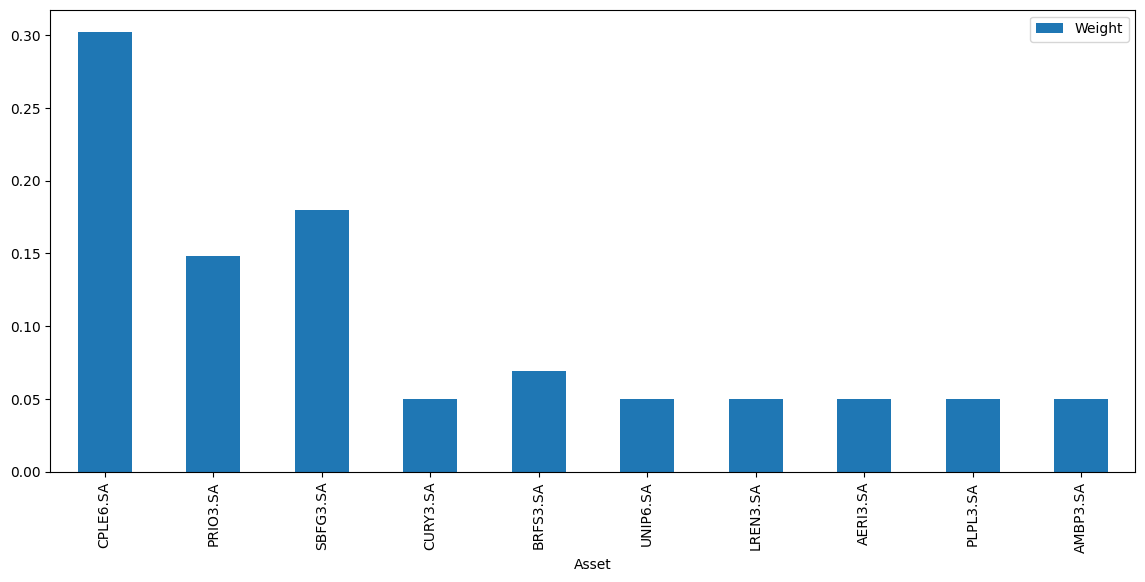

In [114]:
asset_analysis.plot_comparison_of_weights(top_assets_weights)

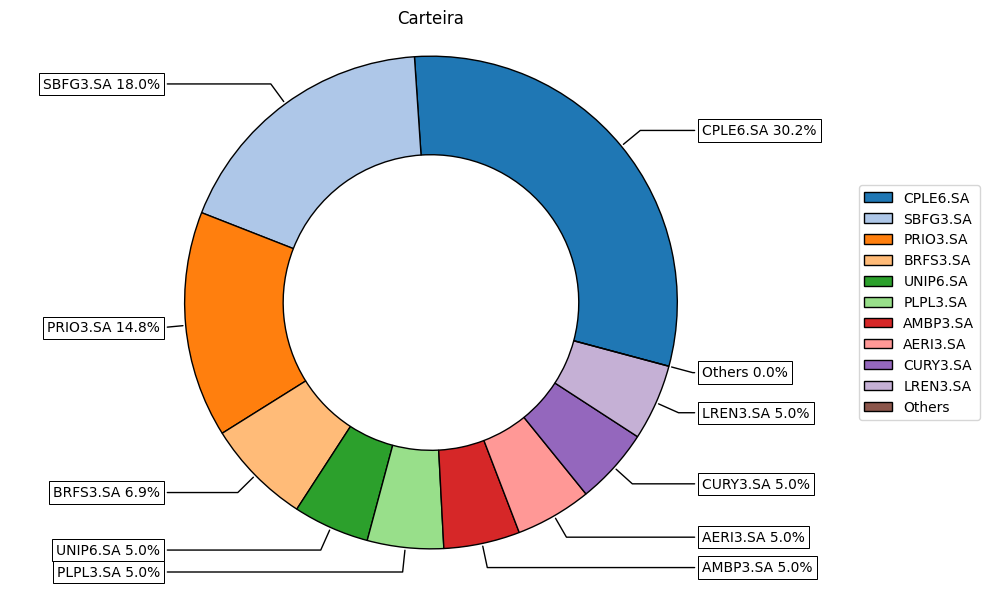

In [115]:
asset_analysis.plot_portfolio_composition(top_assets_weights, "Carteira")